<a href="https://colab.research.google.com/github/carlosinator/cil-sentiment/blob/main/models_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
%%bash
pip3 install transformers emoji==0.6.0 keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.5/576.5 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.9/851.9 kB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 119.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from pathlib import Path
import tensorflow as tf
import transformers

In [4]:
# reproducibility
transformers.set_seed(0) # sets the seed in random, numpy, and tf

# Data

In [5]:
# copy data to pwd
!gsutil cp "gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt" .
!gsutil cp "gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt" .

filename_train_pos = "train_pos_full_preprocessed_without_duplicates.txt"
filename_train_neg = "train_neg_full_preprocessed_without_duplicates.txt"

Copying gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt...
\ [1 files][ 74.6 MiB/ 74.6 MiB]                                                
Operation completed over 1 objects/74.6 MiB.                                     
Copying gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt...
| [1 files][ 91.6 MiB/ 91.6 MiB]                                                
Operation completed over 1 objects/91.6 MiB.                                     


In [6]:
from transformers import AutoTokenizer, TFAutoModel, AutoConfig, TFAutoModelForSequenceClassification

# read dataset
dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
dataset_pos_pd['label'] = 0
dataset_neg_pd['label'] = 1
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

# tokenize data set
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
texts = tokenizer.batch_encode_plus(dataset_pd['text'].tolist(),
                                    padding=True, truncation=True,
                                    return_tensors='tf')

dataset = tf.data.Dataset.from_tensor_slices((dict(texts), dataset_pd['label']))

<ipython-input-6-854d5865ecc4>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
<ipython-input-6-854d5865ecc4>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
# split training / validation
AUTOTUNE = tf.data.experimental.AUTOTUNE

val_data_size = int(0.1 * len(dataset_pd.index))
test_data_size = int(0.1 * len(dataset_pd.index))
train_data_size = len(dataset_pd.index) - val_data_size - test_data_size

def get_test_ds(batch_size: int):
  val_ds = dataset.take(val_data_size).batch(batch_size, drop_remainder=True)
  train_ds = dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
  test_ds = dataset.skip(val_data_size + train_data_size).take(test_data_size).batch(batch_size, drop_remainder=True)

  train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

  return test_ds

# Models

In [12]:
# helper function
def remove_trailing_zeros(array):
    last_index = len(array) - 1

    # Find the last non-zero element
    while last_index >= 0 and array[last_index] == 0:
        last_index -= 1

    # Resize the array to exclude trailing zeros
    array = array[0:last_index + 1]

    return array

In [49]:
from dataclasses import dataclass
from typing import List
from enum import Enum
import os
from pathlib import Path
from functools import cached_property

class ExperimentType(Enum):
    READ = "read"
    MINION = "minion"
    BASE = "base"

@dataclass
class Experiment:
    name: str
    lr: float
    units: int
    batch_size: int
    epochs: int
    type_id: ExperimentType

    @property
    def description(self) -> str:
      gru_description = f"GRU_UNITS: {self.units}"
      return f"{self.type_id.value.upper()} (EPOCHS: {self.epochs}, LR: {self.lr}, BATCH_SIZE: {self.batch_size}{', '+gru_description if gru_description else ''})"

    def base_filename(self) -> str:
        type_id_string = ""
        if self.type_id == ExperimentType.READ:
            type_id_string = "paper-read"
        elif self.type_id == ExperimentType.MINION:
            type_id_string = "read"
        elif self.type_id == ExperimentType.BASE:
            type_id_string = "basemodel"

        return f"inference_{type_id_string}_fullmodel_lr{self.lr}_ep{self.epochs}_batchs={self.batch_size}_gru_units={self.units}"

    @cached_property
    def model(self):
        if not Path(self.base_filename()).exists():
          !gsutil cp -r {"gs://cil_2023/models/" + self.base_filename()} .
        return tf.keras.models.load_model(self.base_filename())

    @cached_property
    def gpu_history(self):
      gpu_file_name = f"gpu_hist_{self.base_filename()}.pkl"

      if not Path(gpu_file_name).exists():
        fname = "gs://cil_2023/models/" + gpu_file_name
        !gsutil cp $fname .

      with open(gpu_file_name, 'rb') as file:
        # Load the pickled object
        unpickled_object = pickle.load(file)

        # remove trailing zeros (due to some bugs, this may occur, if gpu measurement does not automatically stop)
        unpickled_object["percent"] = remove_trailing_zeros(unpickled_object["percent"])

        return unpickled_object

In [56]:
# Helper function
def sort_experiments(experiments: List[Experiment]) -> List[Experiment]:
    def sorting_key(experiment):
        type_order = {
            ExperimentType.BASE: 0,
            ExperimentType.READ: 1,
            ExperimentType.MINION: 2
        }
        return type_order[experiment.type_id], experiment.type_id.value

    return sorted(experiments, key=sorting_key)

In [57]:
# List of experiments
EXPERIMENTS: List[Experiment] = [
    Experiment(name="basemodel", lr=2e-5, units=32, batch_size=256, epochs=5, type_id=ExperimentType.BASE),
    Experiment(name="minion_v0", lr=1e-3, units=64, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="minion_v1", lr=1e-3, units=8, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v0", lr=1e-3, units=64, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="minion_v2", lr=3e-4, units=64, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v1", lr=1e-3, units=256, batch_size=256, epochs=5, type_id=ExperimentType.READ),
]

def get_experiment(name: str) -> Experiment:
    for experiment in EXPERIMENTS:
        if experiment.name == name:
            return experiment
    return None

# GPU Stats

In [14]:
A100_p0 = 0.4 # see here for SXM: https://www.nvidia.com/en-us/data-center/a100/
DEFAULT_ENERYG_P0 = A100_p0

In [22]:
def get_duration(experiment: Experiment):
  gpu_hist = experiment.gpu_history
  percent_values = gpu_hist["percent"]
  interval = gpu_hist["interval"]

  total_time_seconds = len(percent_values) * interval

  # Convert total_time_seconds to hours and minutes
  total_time_minutes, seconds = divmod(total_time_seconds, 60)
  hours, minutes = divmod(total_time_minutes, 60)

  print(f"Total time measured: {total_time_seconds} seconds")
  print(f"Total time measured: {hours} hours and {minutes} minutes")
  print(f"Total time measured: {total_time_minutes} minutes and {seconds} seconds")

  # Calculate average time per epoch
  if experiment.epochs > 0:
      average_time_per_epoch_seconds = total_time_seconds / experiment.epochs
      avg_time_minutes, avg_time_seconds = divmod(average_time_per_epoch_seconds, 60)
      avg_time_hours, avg_time_minutes = divmod(avg_time_minutes, 60)
      print(f"Average time per epoch: {avg_time_hours} hours and {avg_time_minutes} minutes and {avg_time_seconds:.2f} seconds")


  return total_time_seconds, hours, minutes

def compute_energy_consumption(experiment: Experiment, p0: float = DEFAULT_ENERYG_P0):
  gpu_hist = experiment.gpu_history
  utilization_percents = gpu_hist["percent"]
  interval = gpu_hist["interval"]

  # Calculate the number of entries per minute
  entries_per_minute = (int)(60 // interval)

  # Check if the utilization_percents length is a multiple of entries_per_minute
  # If not, it means the last minute is incomplete, and we should only consider complete minutes for the calculation
  if len(utilization_percents) % entries_per_minute != 0:
      drop_count = (int)(len(utilization_percents) % entries_per_minute)
      utilization_percents = utilization_percents[:-drop_count]

  # Reshape the utilization_percents to a 2D array with 'entries_per_minute' columns
  utilization_percents = np.array(utilization_percents).reshape(-1, entries_per_minute)

  # Create utilization_percents_per_minutes list by taking the average of each row
  utilization_percents_per_minutes = utilization_percents.mean(axis=1)


  # Compute the total energy consumption
  total_energy_consumption = np.sum(utilization_percents_per_minutes) * p0 / 6000

  # result is in kWH
  return total_energy_consumption

# Accuracy

In [10]:
from sklearn.metrics import accuracy_score, f1_score

def get_scoring(experiment: Experiment):
  model = experiment.model
  test_ds = get_test_ds(experiment.batch_size)

  # Assuming that 'model' is your trained model
  # Assuming that 'dataset' is your batched dataset

  # These lists will store all labels and predictions
  all_labels = []
  all_predictions = []

  # Iterate over batches in the dataset
  for features, labels in test_ds:
      # Predict the outputs for the current batch
      batch_predictions = model.predict(features)
      # Flatten labels and add them to their respective lists
      all_labels.extend(labels.numpy().flatten())
      # Save the batch predictions
      all_predictions.extend(batch_predictions)

  # Convert list of predictions to numpy array
  all_predictions = np.array(all_predictions)

  # Use argmax to get the class with the highest probability for each prediction
  all_predictions_labels = np.argmax(all_predictions, axis=-1)

  # Now we can compute the accuracy and F1 score
  accuracy = accuracy_score(all_labels, all_predictions_labels)
  f1 = f1_score(all_labels, all_predictions_labels, average='macro')

  print("Model accuracy:", accuracy)
  print("Model F1 score:", f1)

  return accuracy, f1, all_labels, all_predictions

# Tests

In [23]:
experiment = get_experiment("minion_v0")
get_duration(experiment)

Total time measured: 9890.0 seconds
Total time measured: 2.0 hours and 44.0 minutes
Total time measured: 164.0 minutes and 50.0 seconds
Average time per epoch: 0.0 hours and 32.0 minutes and 58.00 seconds


(9890.0, 2.0, 44.0)

In [ ]:
experiment = get_experiment("minion_v0")
experiment.base_filename()
scores = get_scoring(experiment)

# Analyze GPU History

In [25]:
def plot_percent_values(datapoints,
                        interval,
                        y_axis_title='GPU Ressource utilization',
                        y_label='GPU Ressource utilization [%]',
                        plot_title='GPU Ressource utilization over Time'):
    # Create a range of time values in minutes
    time_values = np.arange(0, len(datapoints)*interval, interval) / 60

    # Create a DataFrame to hold time and percent values
    df = pd.DataFrame({
        'time [in min]': time_values,
        'GPU Ressource utilization': datapoints
    })

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='time [in min]', y=y_axis_title)

    # Set titles
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel('time [in min]')

    # Display the plot
    plt.show()

Total time measured: 9890.0 seconds
Total time measured: 2.0 hours and 44.0 minutes
Total time measured: 164.0 minutes and 50.0 seconds
Average time per epoch: 0.0 hours and 32.0 minutes and 58.00 seconds


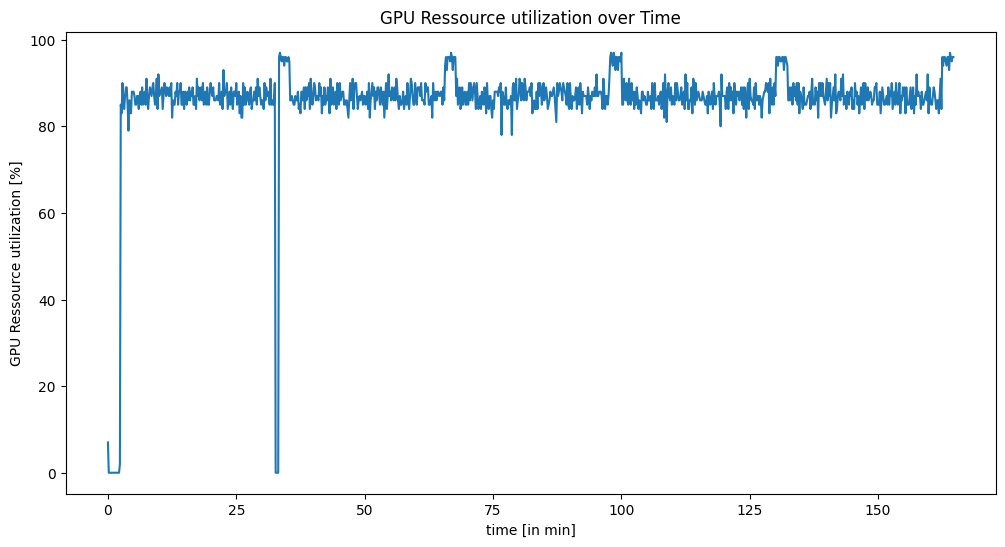

In [26]:
get_duration(experiment)
gpu_hist = experiment.gpu_history
plot_percent_values(datapoints=gpu_hist['percent'], interval=gpu_hist["interval"])

In [28]:
compute_energy_consumption(experiment)

0.9375

## Plot experiment duration


In [58]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_experiment_durations(experiments):
    # sort first
    experiments = sort_experiments(experiments)

    # Create a list to store the experiment data
    experiment_data = []

    # Iterate over all the paths and load the experiment data
    for experiment in experiments:
        total_time_seconds, _, _ = get_duration(experiment)

        # Apply the transformation to the label
        label = experiment.description

        experiment_data.append({"Name": label, "Duration": total_time_seconds})

    # Convert the list to a DataFrame
    df = pd.DataFrame(experiment_data)

    # Ensure the 'Duration' column is numeric
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

    print(df)

    # Create the seaborn plot
    plt.figure(figsize=(10,6))
    plot = sns.barplot(y="Name", x="Duration", data=df, orient="h")

    # Add labels for each bar
    #for i in range(df.shape[0]):
    #    plot.text(df.Duration[i], i, df.Name[i], color='black', ha="right")

    # Show the plot
    plt.xlabel('Duration')
    plt.ylabel('Experiment')
    plt.title('Experiment Durations')
    plt.show()


Total time measured: 14660.0 seconds
Total time measured: 4.0 hours and 4.0 minutes
Total time measured: 244.0 minutes and 20.0 seconds
Average time per epoch: 0.0 hours and 48.0 minutes and 52.00 seconds
Total time measured: 9890.0 seconds
Total time measured: 2.0 hours and 44.0 minutes
Total time measured: 164.0 minutes and 50.0 seconds
Average time per epoch: 0.0 hours and 32.0 minutes and 58.00 seconds
Total time measured: 10790.0 seconds
Total time measured: 2.0 hours and 59.0 minutes
Total time measured: 179.0 minutes and 50.0 seconds
Average time per epoch: 0.0 hours and 35.0 minutes and 58.00 seconds
Total time measured: 8490.0 seconds
Total time measured: 2.0 hours and 21.0 minutes
Total time measured: 141.0 minutes and 30.0 seconds
Average time per epoch: 0.0 hours and 28.0 minutes and 18.00 seconds
Total time measured: 7700.0 seconds
Total time measured: 2.0 hours and 8.0 minutes
Total time measured: 128.0 minutes and 20.0 seconds
Average time per epoch: 0.0 hours and 25.0 m

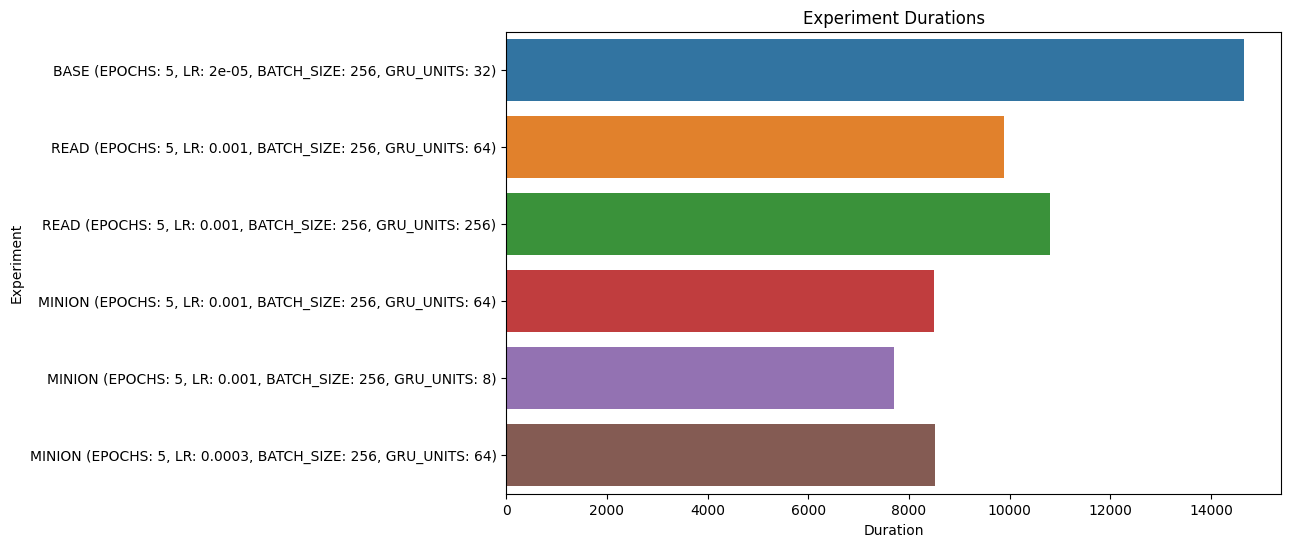

In [59]:
plot_experiment_durations(EXPERIMENTS)